In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [15]:
# Data preparation
csv_path = 'datasets\SN_m_tot_V2.0.csv'

df = pd.read_csv(csv_path, sep=';', header=None, names=["Year", "Month", "Frac_Date", "Sn_mean", "Sn_stdev", "Obs_n", "marker"])
df["Year_Month"] = df.pop("Year").astype(str) + "." + df.pop("Month").astype(str)

date_time = pd.to_datetime(df.pop('Year_Month'), format='%Y.%m')

df.pop("Frac_Date")
df.pop("Sn_stdev")
df.pop("Obs_n")
df.pop("marker")

df.tail()

,Sn_mean
3305,164.1
3306,196.5
3307,215.5
3308,141.4
3309,166.4


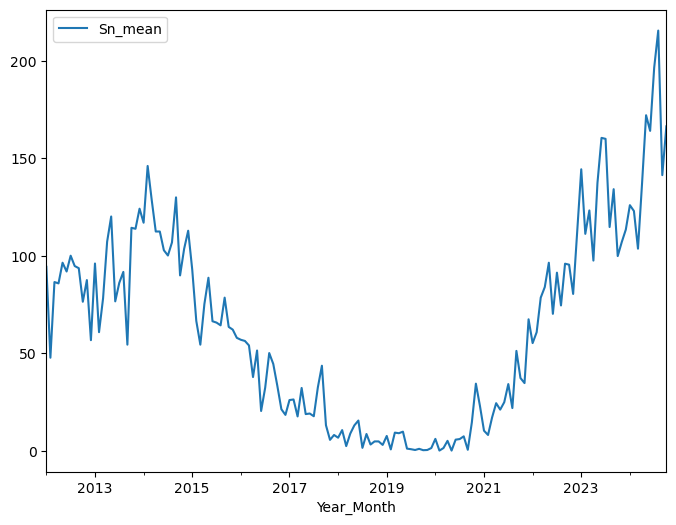

In [16]:
# # plot all available data
plot_cols = ['Sn_mean']
# plot_features = df[plot_cols]
# plot_features.index = date_time # gives labels that identify each row
# _ = plot_features.plot(subplots=True)

# plot a range of data
start_date = '2012-01'
plot_features = df[plot_cols][date_time >= start_date]
plot_features.index = date_time[date_time >= start_date]
_ = plot_features.plot(subplots=True)

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sn_mean,3310.0,81.993716,67.706472,0.0,24.2,68.0,122.7,398.2


In [19]:
# Sn_stdev = df['Sn_stdev']
# bad_Sn_stdev = Sn_stdev == -1.0
# Sn_stdev[bad_Sn_stdev] = 0.0

# Obs_n = df['Obs_n']
# bad_Obs_n = Obs_n == -1.0
# Obs_n[bad_Obs_n] = 0.0

# df.describe().transpose()

In [20]:
print(date_time)

0      1749-01-01
1      1749-02-01
2      1749-03-01
3      1749-04-01
4      1749-05-01
          ...    
3305   2024-06-01
3306   2024-07-01
3307   2024-08-01
3308   2024-09-01
3309   2024-10-01
Name: Year_Month, Length: 3310, dtype: datetime64[ns]


In [24]:
# dtype: datetime64[ns] to Unix timestamp in seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60 # 24 hours * 60 mins * 60 seconds
year = (365.2425)*day

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df.tail()

,Sn_mean,Year sin,Year cos
3305,164.1,0.504156,-0.863612
3306,196.5,0.012321,-0.999924
3307,215.5,-0.497717,-0.867339
3308,141.4,-0.869530,-0.493879
3309,166.4,-1.000000,-0.000462


Text(0.5, 1.0, 'Time of year signal')

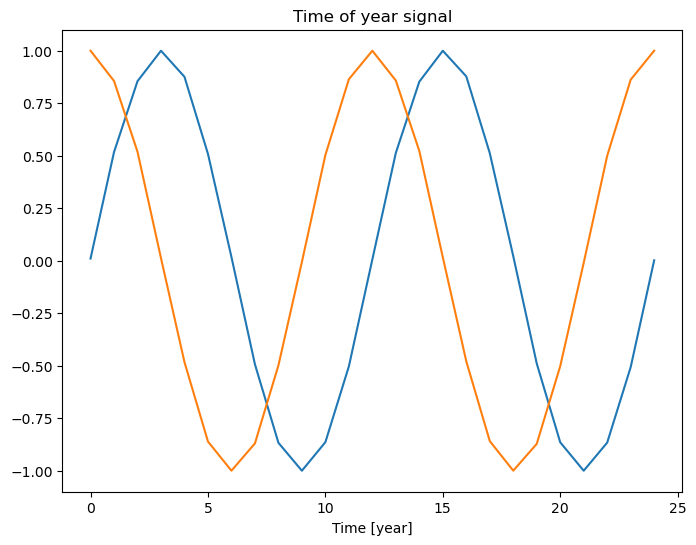

In [22]:
plt.plot(np.array(df['Year sin'])[:25])
plt.plot(np.array(df['Year cos'])[:25])
plt.xlabel('Time [year]')
plt.title('Time of year signal')

In [ ]:
# # Compute the real-valued FFT for the monthly data
# fft = tf.signal.rfft(df['Sn_mean'])  # Perform FFT on the monthly temperature data

# # Create an array of indices corresponding to the frequency bins of the FFT output
# f_per_dataset = np.arange(0, len(fft))

# # Determine the total number of samples (months) and years in the dataset
# n_samples_m = len(df['Sn_mean'])  # Total number of monthly samples
# months_per_year = 12               # Months in a year
# years_per_dataset = n_samples_m / months_per_year

# # Convert the FFT frequency bins into frequencies expressed as cycles per year
# f_per_year = f_per_dataset / years_per_dataset

# # Plot the frequency spectrum
# plt.step(f_per_year, np.abs(fft))
# plt.xscale('log')
# plt.ylim(0, max(np.abs(fft)) * 1.1)  # Adjust y-limit to fit the data
# plt.xlim(0.1, max(plt.xlim()))       # Limit x-axis from 0.1 to max frequency
# plt.xticks([1], labels=['1/Year'])
# _ = plt.xlabel('Frequency (log scale)')


In [27]:
# split dataset

# create a dictionary of column indices
# keys are coulumn names, values are the respective indices
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1] # number of features
print(num_features)

3


C:\Users\HP\AppData\Local\Temp\ipykernel_10224\3095789716.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


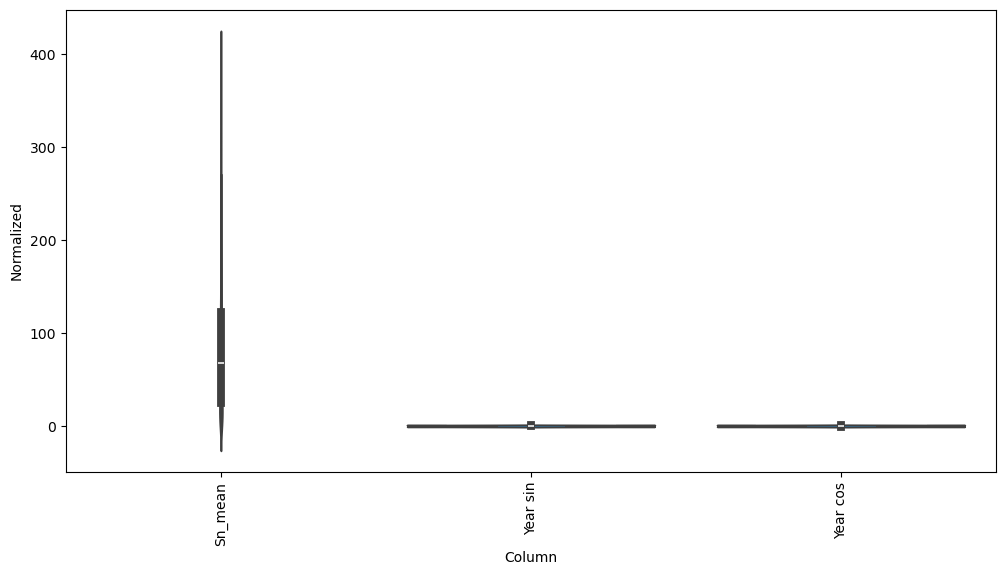

In [31]:
# Normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std.describe().transpose()

# Converts the DataFrame from a wide format (columns for each feature)
# to a long format (2 columns: column names and normalized values).

df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [46]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1
        )

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way, the 'tf.data.Datasets' are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='Sn_mean', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data = data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    # Get and cache an example batch of 'inputs, labels' for plotting.
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # and cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [47]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Sn_mean']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Sn_mean']

In [48]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 3)
Labels shape (batch, time, features): (32, 1, 1)


In [49]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [53]:
baseline = Baseline(label_index=column_indices['Sn_mean'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val,
                                                return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test,
                                            verbose=0, return_dict=True)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2163 - mean_absolute_error: 0.3424  


In [51]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Sn_mean']
)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Sn_mean']

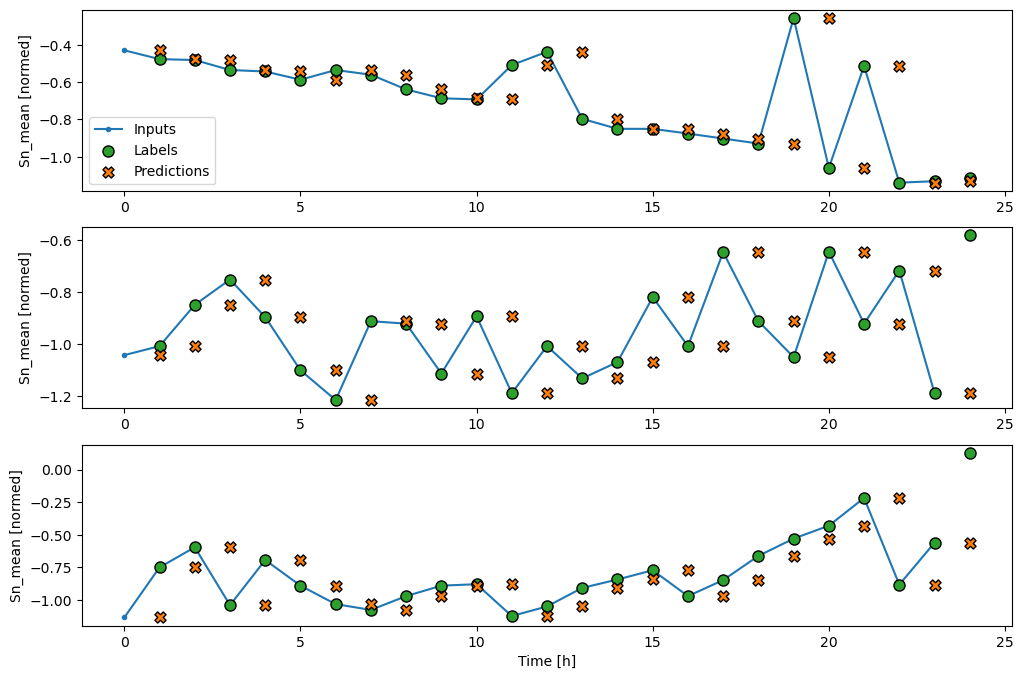

In [52]:
wide_window.plot(baseline)